In [218]:
___Author___='LumberJack Jyss'

In [219]:
print('Global Optimized LumberJack Equities Method\n°OoO_FOREX_Oo0°\nLumberJack Jyss 5779(c)')

Global Optimized LumberJack Equities Method
°OoO_FOREX_Oo0°
LumberJack Jyss 5779(c)


In [220]:
print('Importing librairies...')
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve,confusion_matrix,classification_report
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dense
from keras.utils import to_categorical
%matplotlib inline
print('Librairies imported')

Importing librairies...
Librairies imported


In [221]:
import warnings
import tensorflow as tf
warnings.filterwarnings("ignore")
tf.logging.set_verbosity(tf.logging.ERROR)

In [222]:
df_15min = pd.read_csv('20190526 data prepared.csv')
df_15min = df_15min.iloc[:,1:]
df_15min = df_15min.dropna()
df_15min.reset_index(inplace=True,drop=True)

plt.figure(figsize=(26,20))
sns.heatmap(df_15min.iloc[:,:-1].corr(),annot=True,cmap='rainbow')
plt.show()

In [223]:
df_15min['target_up'].sum(),df_15min['target_down'].sum(),df_15min.isnull().sum().sum()

(76, 76, 0)

In [224]:
delta = round(df_15min.shape[0])
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("# of periods : ",delta)
print('On 80% - 20% slash : ')
print('Bloc 1 : ',bloc1,' periods (',df_15min.iloc[bloc1,0],')\nBloc 2 :',bloc2,' periods (',df_15min.iloc[bloc2,0],')')
print('First period :',df_15min.iloc[0,0])
print('Last period :',df_15min.iloc[df_15min.shape[0]-1,0])


# of periods :  6441
On 80% - 20% slash : 
Bloc 1 :  5153  periods ( 20190321  17:30:00 )
Bloc 2 : 1288  periods ( 20180814  21:15:00 )
First period : 20180604  21:15:00
Last period : 20190531  21:45:00


In [225]:
df_15min.head(0)

,Date,Varop_Spy,Varhl_spy,RSI,75 - RSI,RSI - 25,BBD_Delta_Up,delta5_8,delta8_10,delta10_12,...,delta15_30,delta30_35,delta35_40,delta40_45,delta45_50,delta_tsf,Forcast Oscillator,target_up,target_down,target_value


In [226]:
X = df_15min.iloc[:,1:-3]
#X = X.drop(['Peaks','Valley'],axis=1)
#X = X.drop(['75 - RSI','RSI - 25'],axis=1)
y_up = df_15min.iloc[:,-3].values
y_down = df_15min.iloc[:,-2].values


In [227]:
ytrain_up = y_up[:bloc1]
ytest_up = y_up[bloc1:]
ytrain_down = y_down[:bloc1]
ytest_down = y_down[bloc1:]

Xtrain_up =   X.iloc[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','delta40_45', 'delta45_50']]
Xtrain_down = X.iloc[:bloc1,:] #X.loc[:bloc1-1,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]
Xtest_up =   X.iloc[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','delta40_45', 'delta45_50']]
Xtest_down = X.iloc[bloc1:,:] #X.loc[bloc1:,['Varop_Spy','75 - RSI', 'BBD_Delta_Up']]

In [228]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
#y_up = scaler.fit_transform(np.array(y_up).reshape(-1,1))
#y_down = scaler.fit_transform(np.array(y_down).reshape(-1,1))
y_up = np.array(y_up).reshape(-1,1)
y_down = np.array(y_down).reshape(-1,1)

In [229]:
from collections import Counter
from imblearn.combine import SMOTETomek
print('Original dataset shape_up %s' % Counter(ytrain_up))
print('Original dataset shape_down %s' % Counter(ytrain_down))

Original dataset shape_up Counter({0: 5091, 1: 62})
Original dataset shape_down Counter({0: 5091, 1: 62})


In [230]:
smt = SMOTETomek(random_state=42) #sm = SMOTE(random_state=42)
Xtrain_up, ytrain_up = smt.fit_resample(Xtrain_up, ytrain_up)
Xtrain_down, ytrain_down = smt.fit_resample(Xtrain_down, ytrain_down)

In [231]:
print('Resampled dataset shape %s' % Counter(ytrain_up))
print('Resampled dataset shape %s' % Counter(ytrain_down))

Resampled dataset shape Counter({0: 5090, 1: 5090})
Resampled dataset shape Counter({0: 5091, 1: 5091})


In [232]:
Xtrain_up.shape,Xtrain_down.shape,Xtest_up.shape,Xtest_down.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((10180, 17),
 (10182, 17),
 (1288, 17),
 (1288, 17),
 (10180,),
 (10182,),
 (1288,),
 (1288,))

In [233]:
from keras.layers import Bidirectional
n_steps = Xtrain_up.shape[0]
n_features = Xtrain_up.shape[1]
Xtrain_up = Xtrain_up.reshape((Xtrain_up.shape[0],1,Xtrain_up.shape[1]))
Xtrain_down = Xtrain_down.reshape((Xtrain_down.shape[0],1,Xtrain_down.shape[1]))
Xtest_up = Xtest_up.values.reshape((Xtest_up.shape[0],1,Xtest_up.shape[1]))
Xtest_down = Xtest_down.values.reshape((Xtest_down.shape[0],1,Xtest_down.shape[1]))
ytrain_up = ytrain_up.reshape((ytrain_up.shape[0],1,1))
ytrain_down = ytrain_down.reshape((ytrain_down.shape[0],1,1))
ytest_up = ytest_up.reshape((ytest_up.shape[0],1,1))
ytest_down = ytest_down.reshape((ytest_down.shape[0],1,1))

In [234]:
Xtrain_up.shape,Xtrain_down.shape,Xtest_up.shape,Xtest_down.shape,ytrain_up.shape,ytrain_down.shape,ytest_down.shape,ytest_up.shape

((10180, 1, 17),
 (10182, 1, 17),
 (1288, 1, 17),
 (1288, 1, 17),
 (10180, 1, 1),
 (10182, 1, 1),
 (1288, 1, 1),
 (1288, 1, 1))

In [235]:
print('Processing move_up')
model_up = Sequential()
model_up.add((LSTM(30,return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu',go_backwards=True)))
model_up.add((LSTM(50, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu')))
model_up.add((LSTM(30, return_sequences=True,dropout=0.2, recurrent_dropout=0.2,activation='relu')))
model_up.add(TimeDistributed(Dense(1, activation='sigmoid')))
model_up.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_up.fit(Xtrain_up, ytrain_up, epochs=50, batch_size=32, verbose=1)

Processing move_up
Epoch 1/50
10180/10180 [==============================] - 11s 1ms/step - loss: 0.9622 - acc: 0.5964
Epoch 2/50
10180/10180 [==============================] - 2s 217us/step - loss: 0.5944 - acc: 0.6713
Epoch 3/50
10180/10180 [==============================] - 2s 217us/step - loss: 0.5525 - acc: 0.6997
Epoch 4/50
10180/10180 [==============================] - 2s 217us/step - loss: 0.5271 - acc: 0.7253
Epoch 5/50
10180/10180 [==============================] - 2s 216us/step - loss: 0.4811 - acc: 0.7633
Epoch 6/50
10180/10180 [==============================] - 2s 216us/step - loss: 0.4534 - acc: 0.7856
Epoch 7/50
10180/10180 [==============================] - 2s 225us/step - loss: 0.4147 - acc: 0.8130
Epoch 8/50
10180/10180 [==============================] - 2s 215us/step - loss: 0.3807 - acc: 0.8331
Epoch 9/50
10180/10180 [==============================] - 2s 227us/step - loss: 0.3434 - acc: 0.8554
Epoch 10/50
10180/10180 [==============================] - 2s 230us/step 

In [236]:
print('PRocessing move_down')
model_down = Sequential()
model_down.add((LSTM(50,return_sequences=True,dropout=0.4, recurrent_dropout=0.1,activation='relu',go_backwards=True)))
model_down.add((LSTM(50,return_sequences=True,dropout=0.5, recurrent_dropout=0.1,activation='relu')))
model_down.add((LSTM(50,return_sequences=True,dropout=0.6, recurrent_dropout=0.1,activation='relu')))
model_down.add(TimeDistributed(Dense(1, activation='hard sigmoid')))
model_down.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model_down.fit(Xtrain_down, ytrain_down, epochs=50, batch_size=32, verbose=1)
print('Done')

PRocessing move_down


ValueError: Unknown activation function:hard sigmoid

In [ ]:
ytrain_up = ytrain_up.reshape(len(ytrain_up),)
ytrain_down = ytrain_down.reshape(len(ytrain_down),)

In [ ]:
yhat_up = model_up.predict_classes(Xtest_up)
yhat_down = model_down.predict_classes(Xtest_down)

In [ ]:
score_up = model_up.evaluate(Xtest_up, ytest_up,verbose=1)
score_down = model_down.evaluate(Xtest_down, ytest_down,verbose=1)
score_up,score_down

In [ ]:
yhat_up = yhat_up.reshape(len(yhat_up),)
yhat_down = yhat_down.reshape(len(yhat_down),)
ytest_up = ytest_up.reshape(len(ytest_up),)
ytest_down = ytest_down.reshape(len(ytest_down),)

In [ ]:
confusion_matrix(ytest_up, yhat_up),

In [ ]:
confusion_matrix(ytest_down, yhat_down)

In [ ]:

accuracy_up = accuracy_score(ytest_up, yhat_up)
accuracy_down = accuracy_score(ytest_down, yhat_down)

# La précision permet de mesurer la capacité du modèle à refuser résultats non-pertinents : vrais_positifs/(vrais_positifs+faux_positifs)
precision_up = precision_score(ytest_up, yhat_up)  
precision_down = precision_score(ytest_down, yhat_down) 


# Recall : (vrai_positifs/(vrais_positifs+faux_négatifs))
recall_up = recall_score(ytest_up, yhat_up) 
recall_down = recall_score(ytest_down, yhat_down) 


roc_up=roc_auc_score(ytest_up,yhat_up)
roc_down=roc_auc_score(ytest_down,yhat_down)

In [ ]:
print('RESULTATS UP\n')
print('Accuracy: %.2f%%' % (accuracy_up * 100.0))
print("Precision: %.2f%% " % (precision_up *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_up * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_up *100))
# get probabilities for positive class

print(classification_report(ytest_up, yhat_up))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_up, yhat_up))
print('Matrice de confusion :')
conf_matrix

In [ ]:
print('RESULTATS DOWN\n')
print('Accuracy: %.2f%%' % (accuracy_down * 100.0))
print("Precision: %.2f%% " % (precision_down *100),' => Discrimnination des vrais positifs parmi les faux positifs')
print("Recall: %.2f%% " % (recall_down * 100),' => Positifs trouvés par Golem sur tous les positifs existants')
print("AUC: %.2f%% " % (roc_down *100))
# get probabilities for positive class

print(classification_report(ytest_down, yhat_down))
conf_matrix = pd.DataFrame(index = ['vrais_réels','Faux_réels'])
conf_matrix['Vrais_estimés'] = ['Vrais_positifs','Faux_positifs']
conf_matrix['Faux_estimés'] = ['Faux_négatif','Vrais-négatifs']
print(confusion_matrix(ytest_down, yhat_down))
print('Matrice de confusion :')
conf_matrix

In [215]:
len(df_15min)-(len(df_15min)-bloc1)

5153

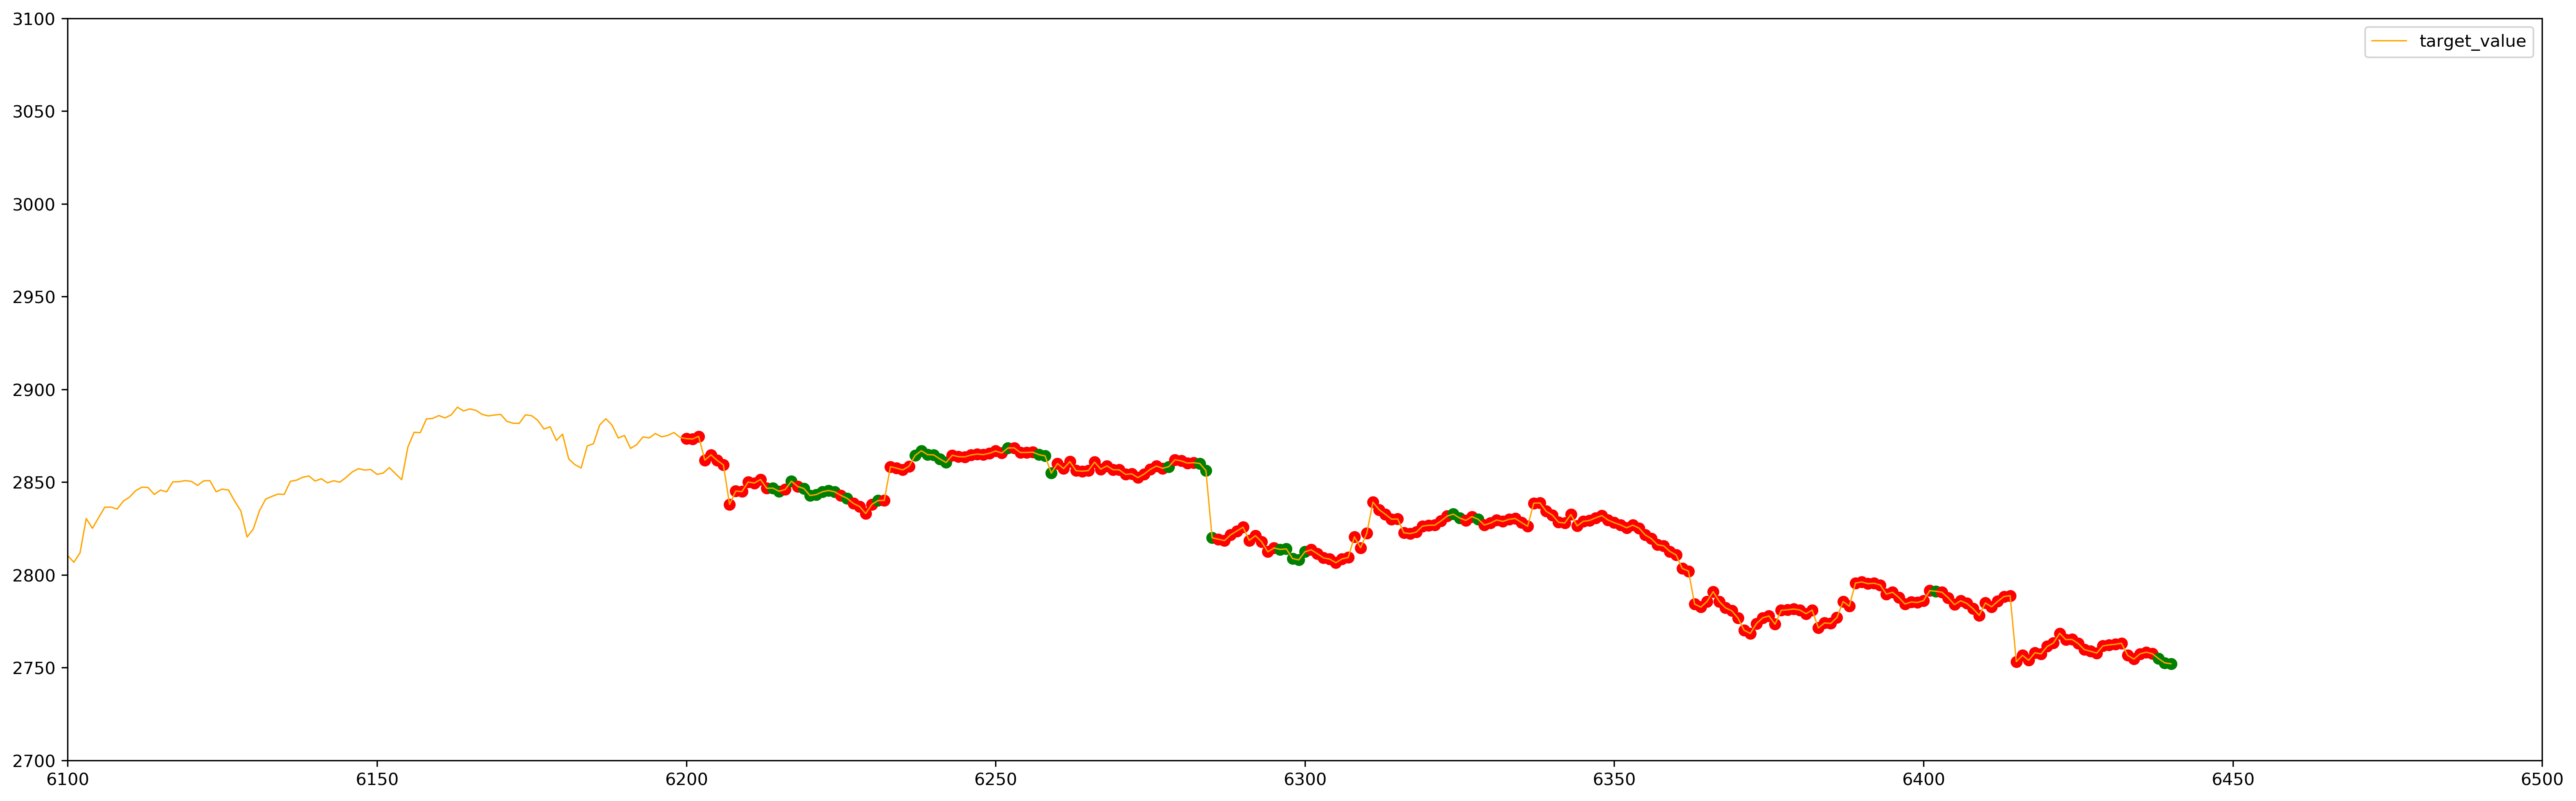

In [216]:
plt.figure(figsize=(26,8),dpi=300)
plt.plot(df_15min['target_value'],color='orange',lw=0.8)
plt.xlim(6100,6500)
plt.ylim(2700,3100)
a = -1
for i in range(len(df_15min)-241,len(df_15min)):
    a+=1
    if yhat_up[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='g',marker='o')
    elif yhat_down[a] == 1:
        plt.scatter(x=df_15min.index[i],y=df_15min.iloc[i,-1],c='r',marker='o')
plt.legend()

In [122]:
sum(yhat_up),sum(yhat_down)

(247, 323)

In [123]:
# save the model to disk
filename = 'finalized_model_long.sav'
pickle.dump(model_up, open(filename, 'wb'))
filename = 'finalized_model_short.sav'
pickle.dump(model_down, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)